In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

import itertools
from sessions_nMAP_EV_SU import selected
from imports import *
from scipy import stats
from maths import pval2text

import pandas as pd

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

all_selected = []
for animal, s_list in selected.items():
    all_selected += s_list

all_selected[:3], len(all_selected)

(['009266_hippoSIT_2023-04-17_17-04-17',
  '009266_hippoSIT_2023-04-18_10-10-37',
  '009266_hippoSIT_2023-04-18_17-03-10'],
 65)

In [5]:
# use a special order
animals = ['57', '013829', '009265', '009266']

In [6]:
electrodes = {
    '013829': [1, 2],
    '009265': [1, 2],
    '009266': [1, 2],
    '57': [1],
    '60': [1, 2]    
}
speed_thresh = 0.04  # m/s

data = []
for i, session in enumerate(all_selected):
    
    # reading data
    animal   = session.split('_')[0]
    session_path = os.path.join(source, animal, session)
    #psth_file  = os.path.join(session_path, 'analysis', 'psth_micro.h5')
    #nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_noconv.h5')
    #nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_with_PSTH.h5')
    #mose_file  = os.path.join(session_path, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    unit_file  = os.path.join(session_path, 'units.h5')
    meta_file  = os.path.join(session_path, 'meta.h5')
    desc_file  = os.path.join(session_path, 'descendants.h5')

    with h5py.File(meta_file, 'r') as f:
        sound_events = np.array(f['processed']['sound_events'])
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        cfg = json.loads(f['processed'].attrs['parameters'])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
    speed_ev = speed[sound_events[:, 2].astype(np.int32)]

    spike_times = {}
    with h5py.File(unit_file, 'r') as f:
        unit_names = [x for x in f if int(x.split('-')[0]) in electrodes[animal]]
    with h5py.File(unit_file, 'r') as f:
        for unit_name in unit_names:
            spike_times[unit_name]  = np.array(f[unit_name]['spike_times'])
            
    # auditory state (BGR, SIL etc.)
    idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
    idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
    idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
    
    # stationary / running
    idxs_sta_ev = np.where(speed_ev < speed_thresh)[0]  # define speed filter here
    idxs_run_ev = np.where(speed_ev > speed_thresh)[0]
   
    # success / miss
    idxs_suc_ev, idxs_mis_ev = [], []
    for tgt_rec in tgt_mx:
        idxs_to_add = list(np.arange(tgt_rec[0], tgt_rec[1] + 1, dtype=np.int32))
        if tgt_rec[4] == 1:
            idxs_suc_ev += idxs_to_add
        else:
            idxs_mis_ev += idxs_to_add
    idxs_suc_ev = np.array(idxs_suc_ev)
    idxs_mis_ev = np.array(idxs_mis_ev)
    
    # collect firing rates
    bins = np.array(list(sound_events[:, 0]) + [sound_events[:, 0][-1] + 0.25])
    for unit_name, strain in spike_times.items():
        spk_counts = np.histogram(strain, bins=bins)[0]
        
        data.append([
            animals.index(animal),
            all_selected.index(session),
            spk_counts[idxs_sil_ev].mean(),
            spk_counts[idxs_bgr_ev].mean(),
            spk_counts[idxs_tgt_ev].mean(),
            spk_counts[idxs_sta_ev].mean(),
            spk_counts[idxs_run_ev].mean(),
            spk_counts[idxs_suc_ev].mean(),
            spk_counts[idxs_mis_ev].mean()
        ])
    
    print(f"Session {session} completed ({i} from {len(all_selected)})\r", end='')
    
data = np.array(data)

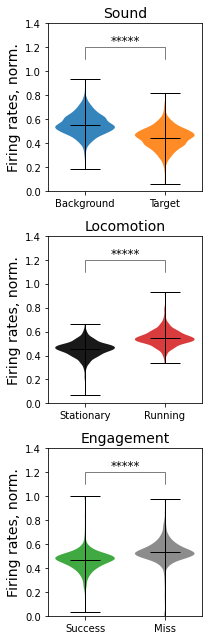

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(3, 9))

comb_idxs = [[2, 4], [5, 6], [7, 8]]
clrs = [['tab:blue', 'tab:orange'], ['black', 'tab:red'], ['tab:green', 'gray']]
labels = [['Background', 'Target'], ['Stationary', 'Running'], ['Success', 'Miss']]
titles = ['Sound', 'Locomotion', 'Engagement']

for i in range(3):
    # data
    m1 = data[:, comb_idxs[i][0]]
    m2 = data[:, comb_idxs[i][1]]
    f_rates_s = np.column_stack([m1/(m1 + m2), m2/(m1 + m2)])

    # violins
    x_pos = np.arange(len(comb_idxs[i]), dtype=np.int32)
    ax = axes[i]
    parts = ax.violinplot(f_rates_s, positions=x_pos, showmeans=True, showmedians=False, widths=0.75)
    for j, pc in enumerate(parts['bodies']):
        pc.set_facecolor(clrs[i][j])
        #pc.set_edgecolor(colors[i])
        pc.set_alpha(0.9)
    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

    # stats
    st, pv = stats.ttest_ind(f_rates_s[:, 0], f_rates_s[:, 1])
    x1, x2 = x_pos[0], x_pos[1]
    y, h = 1.1, 0.1
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, color='black')
    ax.text((x1+x2)*.5, y+h, pval2text(pv), ha='center', va='bottom', color='black', fontsize=12)
    
    ax.set_ylim(0, 1.4)
    ax.set_title(titles[i], fontsize=14)
    ax.set_ylabel('Firing rates, norm.', fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels[i], rotation=0)
    
fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'sound_locomotion_engagement.png'), dpi=300)